In [1]:
import numpy as np
import pandas as pd
from math import sqrt,pi,exp

In [2]:
class Naive_Bayes:
    def __init__(self):
        return
    
    def separate(self,feature,label):
        separated = dict()
        label_list = np.unique(label)
        for i in label_list:
            separated[i] = feature[label==i]
    
        return label_list, separated
    
    # Calculate the Gaussian probability distribution function for x
    def calculate_probability(self,x, mean, stdev):
        exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
        return (1 / (sqrt(2 * pi) * stdev)) * exponent
    
    def class_probabilities(self,x,label_list,separated):
        probabilities = []
        
        for class_num in range(len(separated)):
            class_value = label_list[class_num]
            class_data = separated[class_value]
        
            mean = np.mean(class_data,axis=0)
            std = np.std(class_data,axis=0)

            probability = class_data.shape[0]
            for idx in  range(class_data.shape[1]): 
                probability *= self.calculate_probability(x[idx],mean[idx],std[idx])
            
            probabilities.append(probability)

        return np.array(probabilities)
    
    def fit(self, feature, label):
        self.label_list, self.separated = self.separate(feature,label)
        
        
    def predict(self, feature):
        
        prob = []
        
        for idx in range(len(feature)):
            prob.append(self.class_probabilities(feature[idx],self.label_list,self.separated))
           
        pred = np.argmax(prob,axis=1)
        pred = self.label_list[pred]
        
        return np.array(prob),pred

In [3]:
class Gaussian_Bayes:
    def __init__(self):
        return
    
    def separate(self,feature,label):
        separated = dict()
        label_list = np.unique(label)
        for i in label_list:
            separated[i] = feature[label==i]
    
        return label_list, separated
    
    
    def class_probabilities(self,x,label_list,separated):
        probabilities = []
        
        for class_num in range(len(separated)):
            class_value = label_list[class_num]
            class_data = separated[class_value]
            
            mean = np.mean(class_data,axis=0)   
            cov = ((class_data-mean).T@(class_data-mean)) / (class_data.shape[0])

            probability = self.pdf(x,mean,cov)
            
            probabilities.append(probability)

        return np.array(probabilities)
    
    def fit(self, feature, label):
        self.label_list, self.separated = self.separate(feature,label)
        
    
    def pdf(self,x,mean,cov):
        k = cov.shape[0]
        a = (2*pi)**(-k/2)
        b = 1/sqrt(np.linalg.det(cov))
        c = exp( (-1/2) * ((x-mean)@np.linalg.inv(cov)@(x-mean).T ) )
       
        ans = ( a * b * c) 
        
        return ans
        
    def predict(self, feature):
        
        prob = []
      
        a = np.mean(self.separated[0],axis=0)   
       
        b = ((self.separated[0]-a).T@(self.separated[0]-a)) / (self.separated[0].shape[0])
        
        self.pdf(self.separated[0][0],a,b)
        
        for idx in range(len(feature)):
            prob.append(self.class_probabilities(feature[idx],self.label_list,self.separated))
        
        pred = np.argmax(prob,axis=1)
        pred = self.label_list[pred]
        
        return np.array(prob),pred

In [4]:
class Perceptron:
    def __init__(self,eta=0.01,n_iter=50,threshold=0):
        self.eta = eta
        self.n_iter = n_iter
        self.threshold = threshold
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        for i in range(self.n_iter):
            for Xi,target in zip(X,y):
                update = self.eta*(target - self.calc_ans(Xi))
                self.w_[1:] += update*Xi
                self.w_[0] += update
                
    def net_input(self, X):
        return np.dot(X,self.w_[1:])+self.w_[0]
    
    def calc_ans(self, x):
        if self.net_input(x)>=self.threshold:
            return 1
        else:
            return 0

    def predict(self, X):
        predict = []
        prob = []
        for idx in range(len(X)):  
            prob.append(self.net_input(X[idx]))
            predict.append(self.calc_ans(X[idx]))
            
        return np.array(prob),np.array(predict)

In [5]:
def accuracy(true,pred):
    return np.sum(true==pred)/len(true)

In [6]:
def confusion_mat(true,pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

In [7]:
import matplotlib.pyplot as plt
def ROC_plot(fpr,tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def predict_result(score,threshold):
    pred = np.zeros([score.shape[0]]).astype(np.int)
    pred[score>threshold] = 1
    return pred

In [9]:
def ROC(label,score):
    threshold = np.max(score)+1
    desc_score_indices = np.sort(score, kind="mergesort")[::-1]
    
    fpr_collect = []
    tpr_collect = []
    threshold_collect = []
    for i in range(len(desc_score_indices)): 
        pred = predict_result(score,threshold)
        matrix = confusion_mat(label,pred)

        tn = matrix[0][0]
        fp = matrix[0][1]
        fn = matrix[1][0]
        tp = matrix[1][1]

        fpr = fp/(fp+tn)
        tpr = tp/(tp+fn)
        
        fpr_collect.append(fpr)
        tpr_collect.append(tpr)
        threshold_collect.append(threshold)
        
        threshold = desc_score_indices[i]
    
    return np.array(fpr_collect),np.array(tpr_collect),threshold_collect

In [10]:
def AUC(x,y):
    return np.trapz(y, x)

In [11]:
# "Breast Cancer Wisconsin (Diagnostic) Data Set"
breast_cancer_feature = np.loadtxt("wdbc.data",dtype=np.str,delimiter=',')[:,2:-1].astype(float)
label_map = np.loadtxt("wdbc.data",dtype=np.str,delimiter=',')[:,1] #B0 M1
breast_cancer_label = np.zeros([len(label_map)],dtype=np.int)
breast_cancer_label[label_map=='M'] = 1

In [12]:
df_feature = breast_cancer_feature
df_label = breast_cancer_label
feature_num = df_feature.shape[1]

In [13]:
class LDA:
    def __init__(self):
        return
    
    def fit(self, feature, label):
        feature_num = feature.shape[1]
        
        pos_feature = feature[np.where(label==1)]
        neg_feature = feature[np.where(label==0)]
        
        pos_means = np.mean(pos_feature,axis=0).reshape(1,feature_num)
        neg_means = np.mean(neg_feature,axis=0).reshape(1,feature_num)
        means = np.mean(train_feature,axis=0).reshape(1,feature_num)
        
        # Compute the within class scatter matrices
        within_class_scatter_matrix =  ((pos_feature - pos_means).T @ (pos_feature - pos_means)) \
                + ((neg_feature - neg_means).T @ (neg_feature - neg_means))
        
        # Compute the between class scatter matrices
        between_class_scatter_matrix  = (len(pos_feature)* (pos_means-means).T @ (pos_means-means))\
                + (len(neg_feature)* (neg_means-means).T @ (neg_means-means))
        
        # Compute the eigenvectors and corresponding eigenvalues for the scatter matrices
        eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix)@(between_class_scatter_matrix))
        
        #Sort the eigenvalues and select the top k
        pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
        pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
        
        # Create a new matrix containing eigenvectors that map to the k eigenvalues
        self.w_matrix = np.hstack((pairs[0][1].reshape(feature_num,1), pairs[1][1].reshape(feature_num,1))).real
    
    def transform(self,feature):
        return np.array(feature@(self.w_matrix))

In [14]:
# pick 10% of data for test
np.random.seed(124)
msk = np.random.rand(len(df_feature)) < 0.9
test_feature = df_feature[~msk]
test_label = df_label[~msk]

train_feature = df_feature[msk]
train_label = df_label[msk]

In [15]:
lda = LDA()
lda.fit(train_feature,train_label)

In [16]:
# Obtain the new features (i.e. LDA components) 
train_feature_LDA = lda.transform(train_feature)
test_feature_LDA = lda.transform(test_feature)

Linear Classifier/testing
Accuracy: 0.9310344827586207
Confusion Matrix:
[[37.  4.]
 [ 0. 17.]]
AUC: 0.9383070301291248


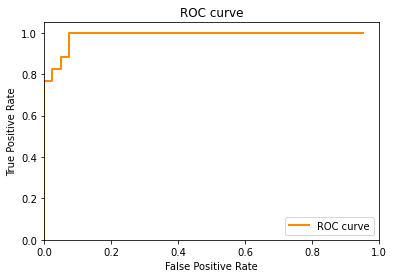

In [17]:
linear_classifier = Perceptron(n_iter=1000)
linear_classifier.fit(train_feature,train_label)

prob,pred = linear_classifier.predict(test_feature)
print("Linear Classifier/testing")
print("Accuracy:",accuracy(test_label, pred))
print("Confusion Matrix:")
print(confusion_mat(test_label, pred))
fpr, tpr, thresholds =  ROC(test_label,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

Linear Classifier/testing
Accuracy: 0.9482758620689655
Confusion Matrix:
[[41.  0.]
 [ 3. 14.]]
AUC: 0.9512195121951219


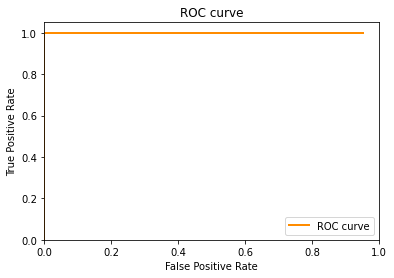

In [20]:
linear_classifier = Perceptron(n_iter=1000)
linear_classifier.fit(train_feature_LDA,train_label)

prob,pred = linear_classifier.predict(test_feature_LDA)
print("Linear Classifier/testing")
print("Accuracy:",accuracy(test_label, pred))
print("Confusion Matrix:")
print(confusion_mat(test_label, pred))
fpr, tpr, thresholds =  ROC(test_label,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

In [21]:
def plot_contours(xx, yy, model, **params):
    meshgrid = np.c_[xx.ravel(), yy.ravel()]
    prob, pred  = model.predict(meshgrid)
    Z =  np.array(pred).reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)    
    return out   

In [22]:
X0 = train_feature_LDA[:,0]
X1 = train_feature_LDA[:,1]

In [23]:
x_min = np.min(X0) - 0.1
x_max = np.max(X0) + 0.1
y_min = np.min(X1) - 0.1
y_max = np.max(X1) + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                         np.arange(y_min, y_max, 0.005))

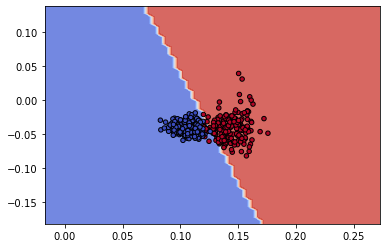

In [24]:
plot_contours(xx, yy, linear_classifier,
                cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=train_label, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.show()

In [25]:
class PCA:
    def __init__(self):
        return
    def fit(self,feature, component=2):
        feature_num = feature.shape[1]
        
        eig_vecs, eig_vals, V = np.linalg.svd(feature.T)
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        
        self.component = np.hstack((eig_pairs[0][1].reshape(feature_num,1), 
                          eig_pairs[1][1].reshape(feature_num,1)))
        
        for i in range(2,component):
            self.component = np.hstack((self.component, eig_pairs[i][1].reshape(feature_num,1)))
    def transform(self,feature):
        return feature@self.component

In [26]:
# standardization data
def standardize(data):
    mean = data.mean(axis=0)
    out = data - mean
    out /= np.std(out)
    return out

In [27]:
standard_train_feature = standardize(train_feature)
standard_test_feature = standardize(test_feature)

In [28]:
pca = PCA()
pca.fit(standard_train_feature,component=2)

In [29]:
train_feature_PCA = pca.transform(standard_train_feature)
test_feature_PCA = pca.transform(standard_test_feature)

Linear Classifier/testing
Accuracy: 0.896551724137931
Confusion Matrix:
[[37.  4.]
 [ 2. 15.]]
AUC: 0.9325681492109038


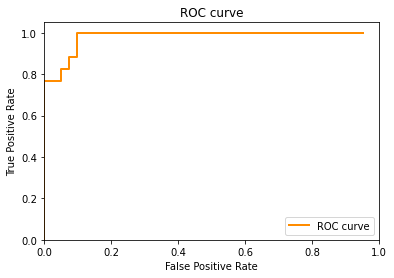

In [32]:
linear_classifier = Perceptron(n_iter=1000)
linear_classifier.fit(train_feature_PCA,train_label)

prob,pred = linear_classifier.predict(test_feature_PCA)
print("Linear Classifier/testing")
print("Accuracy:",accuracy(test_label, pred))
print("Confusion Matrix:")
print(confusion_mat(test_label, pred))
fpr, tpr, thresholds =  ROC(test_label,prob)
print("AUC:",AUC(fpr,tpr))
ROC_plot(fpr,tpr)

In [33]:
X0 =train_feature_PCA [:,0]
X1 =train_feature_PCA [:,1]

In [34]:
x_min = np.min(X0) - 1
x_max = np.max(X0) + 1
y_min = np.min(X1) - 1
y_max = np.max(X1) + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

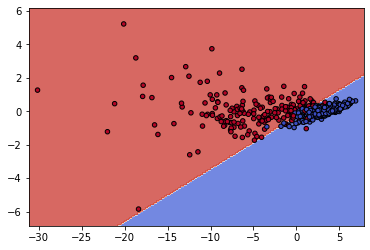

In [35]:
plot_contours(xx, yy, linear_classifier,
                cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=train_label, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.show()